# Trading Signals

---

### Import Libraries and Dependencies

In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
import hvplot.pandas
import talib

### Read CSV / API into Pandas DataFrame

In [2]:
# Loading data
file_path = Path("Resources/Yahoo Finance/GOOG.csv")
goog_df = pd.read_csv(file_path, index_col=0)
goog_df.head()


,High,Low,Open,Close,Volume,Adj Close,Ticker
Date,,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,312.204773,GOOG
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,310.829926,GOOG
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,302.994293,GOOG
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,295.940735,GOOG
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,299.885956,GOOG


### Preparing Data

In [3]:
goog_df = goog_df.drop(columns=['Adj Close', 'Ticker'])

stock_high = goog_df['High']
stock_low = goog_df['Low']
stock_open =goog_df['Open']
stock_close = goog_df['Close']
stock_volume = goog_df['Volume']
goog_df

,High,Low,Open,Close,Volume
Date,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0
...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0


### Calculate Daily Returns and Target Column

In [4]:
# Calculate daily return
goog_df['Returns'] = goog_df['Close'].dropna().pct_change()
goog_df

,High,Low,Open,Close,Volume,Returns
Date,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,NaN
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,-0.004404
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,-0.025209
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,-0.023280
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,0.013331
...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,-0.003914
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,0.012534
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,-0.006256


 ### Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [5]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
goog_df['fast_close'] = goog_df['Close'].ewm(halflife=short_window).mean()
goog_df['slow_close'] = goog_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
goog_df['crossover_long'] = np.where(goog_df['fast_close'] > goog_df['slow_close'], 1.0, 0.0)
goog_df['crossover_short'] = np.where(goog_df['fast_close'] < goog_df['slow_close'], -1.0, 0.0)
goog_df['crossover_signal'] = goog_df['crossover_long'] + goog_df['crossover_short']

goog_df.head()

,High,Low,Open,Close,Volume,Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,NaN,312.204773,312.204773,0.0,0.0,0.0
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,-0.004404,311.288208,311.493534,0.0,-1.0,-1.0
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,-0.025209,306.548828,308.461971,0.0,-1.0,-1.0
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,-0.023280,300.891178,304.999083,0.0,-1.0,-1.0
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,0.013331,300.372354,303.830019,0.0,-1.0,-1.0


###  Plot Exponential Moving Average of Closing Prices

<AxesSubplot:xlabel='Date'>

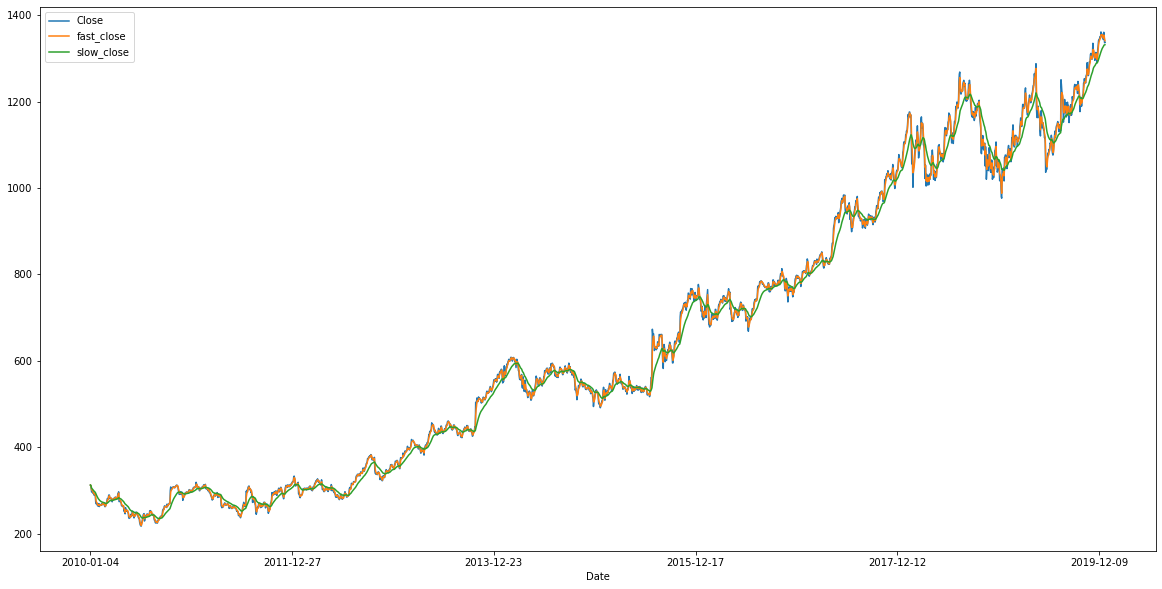

In [6]:
# Plot the EMA of BTC/USD closing prices
goog_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

###  Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [7]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
goog_df['fast_vol'] = goog_df['Returns'].ewm(halflife=short_vol_window).std()
goog_df['slow_vol'] = goog_df['Returns'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
goog_df['vol_trend_long'] = np.where(goog_df['fast_vol'] < goog_df['slow_vol'], 1.0, 0.0)
goog_df['vol_trend_short'] = np.where(goog_df['fast_vol'] > goog_df['slow_vol'], -1.0, 0.0) 
goog_df['vol_trend_signal'] = goog_df['vol_trend_long'] + goog_df['vol_trend_short']

goog_df

,High,Low,Open,Close,Volume,Returns,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,NaN,312.204773,312.204773,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,-0.004404,311.288208,311.493534,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,-0.025209,306.548828,308.461971,0.0,-1.0,-1.0,0.014711,0.014711,0.0,-1.0,-1.0
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,-0.023280,300.891178,304.999083,0.0,-1.0,-1.0,0.009104,0.011276,1.0,0.0,1.0
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,0.013331,300.372354,303.830019,0.0,-1.0,-1.0,0.022598,0.018580,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,-0.003914,1347.043424,1327.089825,1.0,0.0,1.0,0.002890,0.007127,1.0,0.0,1.0
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,0.012534,1353.721724,1329.320509,1.0,0.0,1.0,0.009477,0.007490,0.0,-1.0,-1.0
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,-0.006256,1352.805869,1330.831921,1.0,0.0,1.0,0.009604,0.007514,0.0,-1.0,-1.0


 ### Plot Exponential Moving Average of Daily Return Volatility

<AxesSubplot:xlabel='Date'>

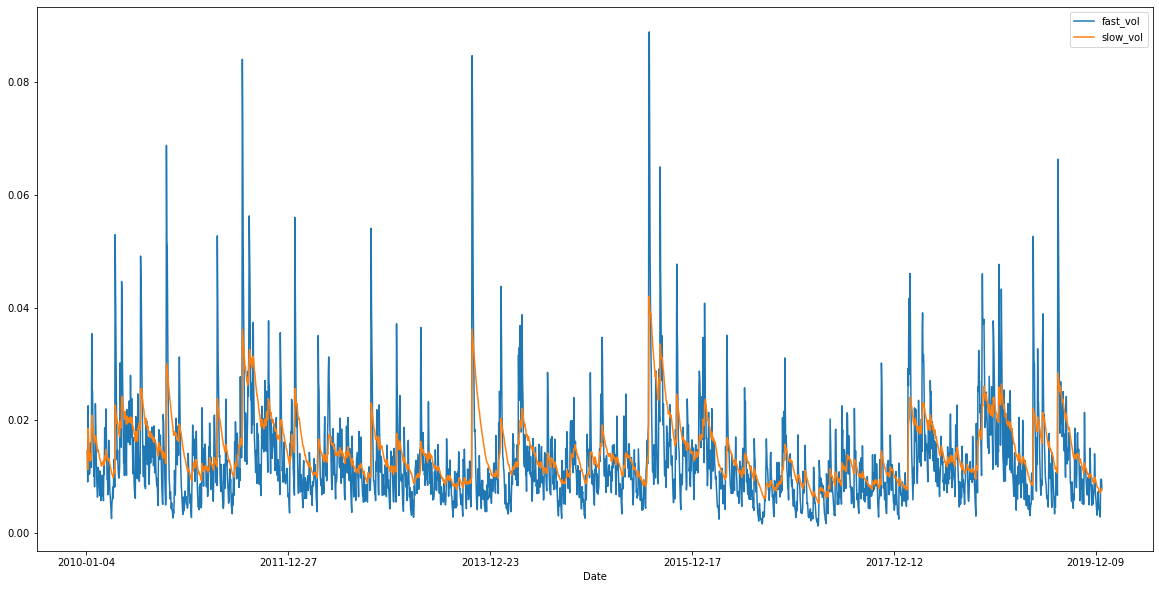

In [8]:
# Plot the EMA of GOOG daily return volatility
goog_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

###  Construct Bollinger Band (Trading Signal, Feature Three)

In [9]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
goog_df['bollinger_mid_band'] = goog_df['Close'].rolling(window=bollinger_window).mean()
goog_df['bollinger_std'] = goog_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
goog_df['bollinger_upper_band']  = goog_df['bollinger_mid_band'] + (goog_df['bollinger_std'] * 1)
goog_df['bollinger_lower_band']  = goog_df['bollinger_mid_band'] - (goog_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
goog_df['bollinger_long'] = np.where(goog_df['Close'] < goog_df['bollinger_lower_band'], 1.0, 0.0)
goog_df['bollinger_short'] = np.where(goog_df['Close'] > goog_df['bollinger_upper_band'], -1.0, 0.0)
goog_df['bollinger_signal'] = goog_df['bollinger_long'] + goog_df['bollinger_short']

goog_df

,High,Low,Open,Close,Volume,Returns,fast_close,slow_close,crossover_long,crossover_short,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,NaN,312.204773,312.204773,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,-0.004404,311.288208,311.493534,0.0,-1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,-0.025209,306.548828,308.461971,0.0,-1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,-0.023280,300.891178,304.999083,0.0,-1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,0.013331,300.372354,303.830019,0.0,-1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,-0.003914,1347.043424,1327.089825,1.0,0.0,...,1.0,0.0,1.0,1335.213513,21.434202,1356.647715,1313.779311,0.0,0.0,0.0
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,0.012534,1353.721724,1329.320509,1.0,0.0,...,0.0,-1.0,-1.0,1337.556012,21.502000,1359.058012,1316.054012,0.0,-1.0,-1.0
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,-0.006256,1352.805869,1330.831921,1.0,0.0,...,0.0,-1.0,-1.0,1339.501013,20.914233,1360.415246,1318.586780,0.0,0.0,0.0


### Plot Bollinger Bands

<AxesSubplot:xlabel='Date'>

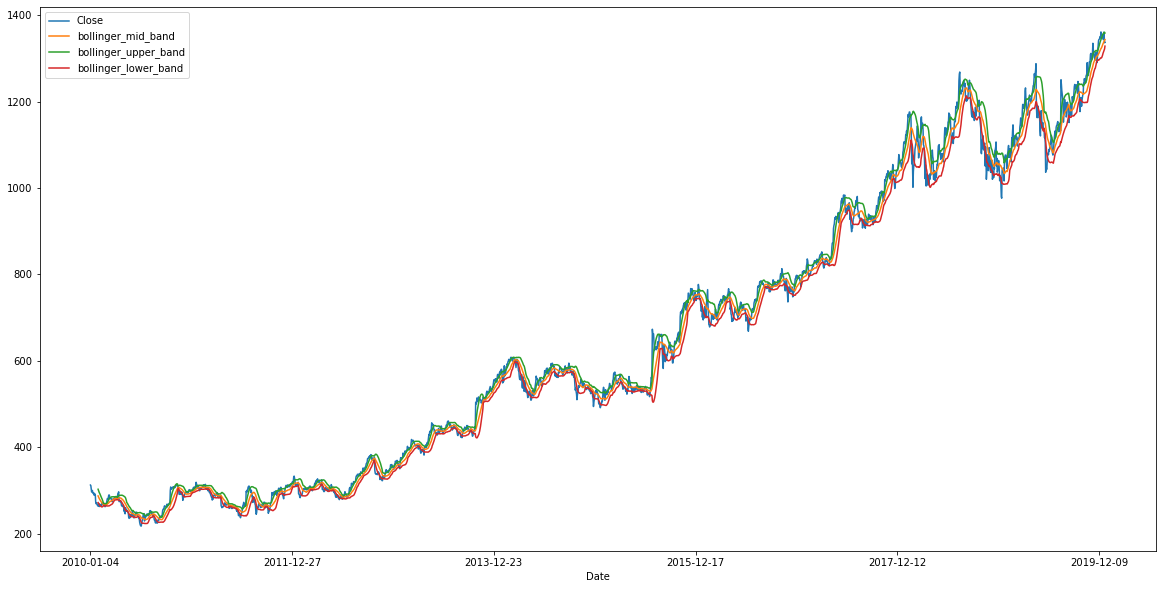

In [12]:
 # Plot the Bollinger Bands for BTC/USD closing prices
goog_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

### Construct Bollinger Band (using talib)

In [13]:
# Compute Bollinger Bands
goog_df['BB Upper'], goog_df['BB middle'], goog_df['BB Lower'] = talib.BBANDS(stock_close)
goog_df

,High,Low,Open,Close,Volume,Returns,fast_close,slow_close,crossover_long,crossover_short,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Entry/Exit,BB Upper,BB middle,BB Lower
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,NaN,312.204773,312.204773,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,-0.004404,311.288208,311.493534,0.0,-1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,-0.025209,306.548828,308.461971,0.0,-1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,-0.023280,300.891178,304.999083,0.0,-1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,0.013331,300.372354,303.830019,0.0,-1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,316.898420,304.371136,291.843853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,-0.003914,1347.043424,1327.089825,1.0,0.0,...,21.434202,1356.647715,1313.779311,0.0,0.0,0.0,0.0,1358.436561,1350.130005,1341.823449
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,0.012534,1353.721724,1329.320509,1.0,0.0,...,21.502000,1359.058012,1316.054012,0.0,-1.0,-1.0,-1.0,1363.464502,1351.686011,1339.907519
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,-0.006256,1352.805869,1330.831921,1.0,0.0,...,20.914233,1360.415246,1318.586780,0.0,0.0,0.0,1.0,1361.848934,1350.856006,1339.863078


### Plot Bollinger Bands - calculated with talib - NO SIGNAL

<AxesSubplot:xlabel='Date'>

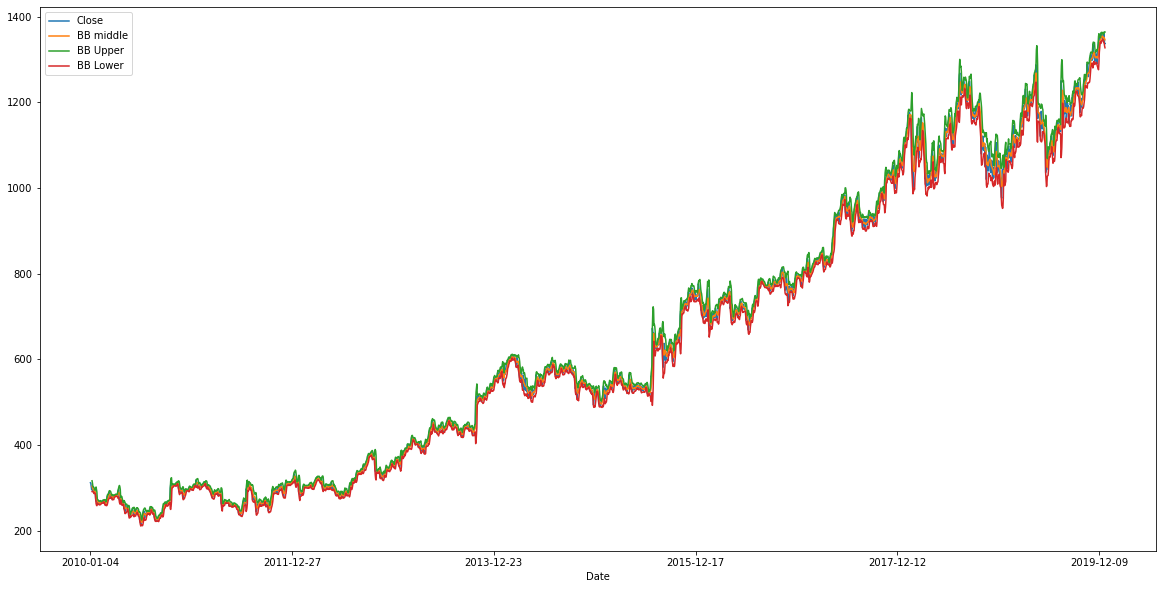

In [14]:
# Plot the Bollinger Bands for BTC/USD closing prices
goog_df[['Close','BB middle','BB Upper','BB Lower']].plot(figsize=(20,10))

### Relative Strength Index -- NO SIGNAL

In [15]:
# Compute Relative Strength Index (RSI)
goog_df['RSI'] = talib.RSI(stock_close)
goog_df

,High,Low,Open,Close,Volume,Returns,fast_close,slow_close,crossover_long,crossover_short,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Entry/Exit,BB Upper,BB middle,BB Lower,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,NaN,312.204773,312.204773,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,-0.004404,311.288208,311.493534,0.0,-1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,-0.025209,306.548828,308.461971,0.0,-1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,-0.023280,300.891178,304.999083,0.0,-1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,0.013331,300.372354,303.830019,0.0,-1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,316.898420,304.371136,291.843853,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,-0.003914,1347.043424,1327.089825,1.0,0.0,...,1356.647715,1313.779311,0.0,0.0,0.0,0.0,1358.436561,1350.130005,1341.823449,58.411350
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,0.012534,1353.721724,1329.320509,1.0,0.0,...,1359.058012,1316.054012,0.0,-1.0,-1.0,-1.0,1363.464502,1351.686011,1339.907519,65.243314
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,-0.006256,1352.805869,1330.831921,1.0,0.0,...,1360.415246,1318.586780,0.0,0.0,0.0,1.0,1361.848934,1350.856006,1339.863078,59.889141


### Plot the Relative Strength Index

<AxesSubplot:xlabel='Date'>

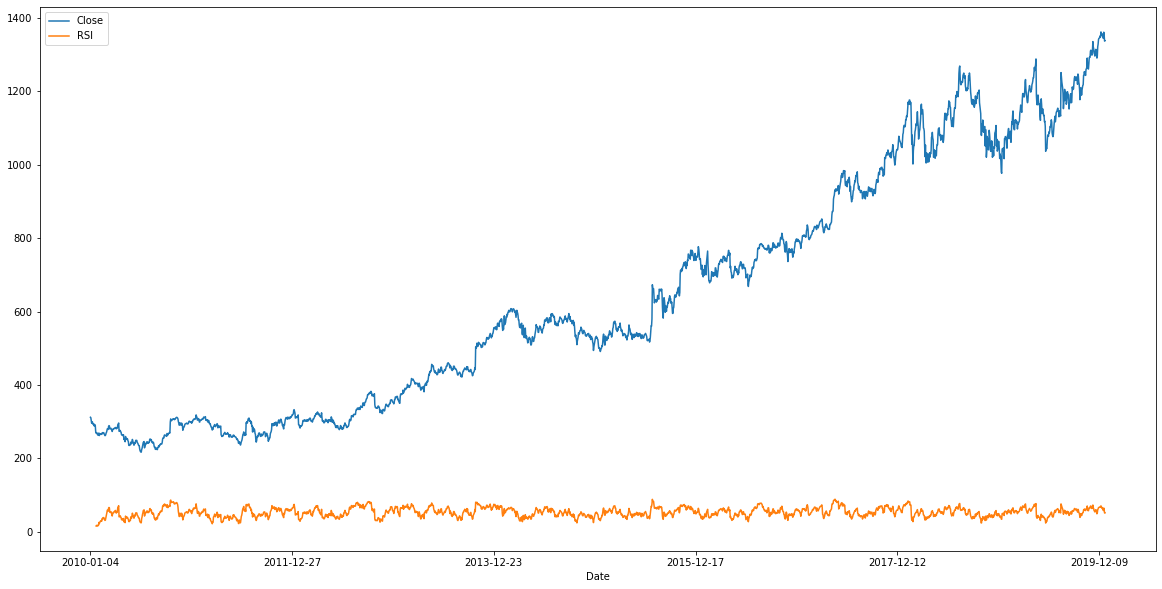

In [16]:
# Plot the Relative Strength Index closing prices
goog_df[['Close','RSI']].plot(figsize=(20,10))

### Compute Average Directional Index (ADX) -- NO SIGNAL

In [17]:
# Compute Average Directional Index (ADX)
goog_df['ADX'] = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)
goog_df.tail()

,High,Low,Open,Close,Volume,Returns,fast_close,slow_close,crossover_long,crossover_short,...,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Entry/Exit,BB Upper,BB middle,BB Lower,RSI,ADX
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,-0.003914,1347.043424,1327.089825,1.0,0.0,...,1313.779311,0.0,0.0,0.0,0.0,1358.436561,1350.130005,1341.823449,58.411350,32.184699
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,0.012534,1353.721724,1329.320509,1.0,0.0,...,1316.054012,0.0,-1.0,-1.0,-1.0,1363.464502,1351.686011,1339.907519,65.243314,32.763481
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,-0.006256,1352.805869,1330.831921,1.0,0.0,...,1318.586780,0.0,0.0,0.0,1.0,1361.848934,1350.856006,1339.863078,59.889141,33.457315
2019-12-30,1353.000000,1334.020020,1350.000000,1336.140015,1050900.0,-0.011650,1344.472942,1331.187389,1.0,0.0,...,1321.755939,0.0,0.0,0.0,0.0,1364.409978,1348.166016,1331.922053,51.470368,32.487466
2019-12-31,1338.000000,1329.084961,1330.109985,1337.020020,961800.0,0.000659,1340.746481,1331.577982,1.0,0.0,...,1328.248562,0.0,0.0,0.0,0.0,1364.255637,1345.802026,1327.348416,51.877410,31.139490


### Create Model and Make Pedictions

<AxesSubplot:xlabel='Date'>

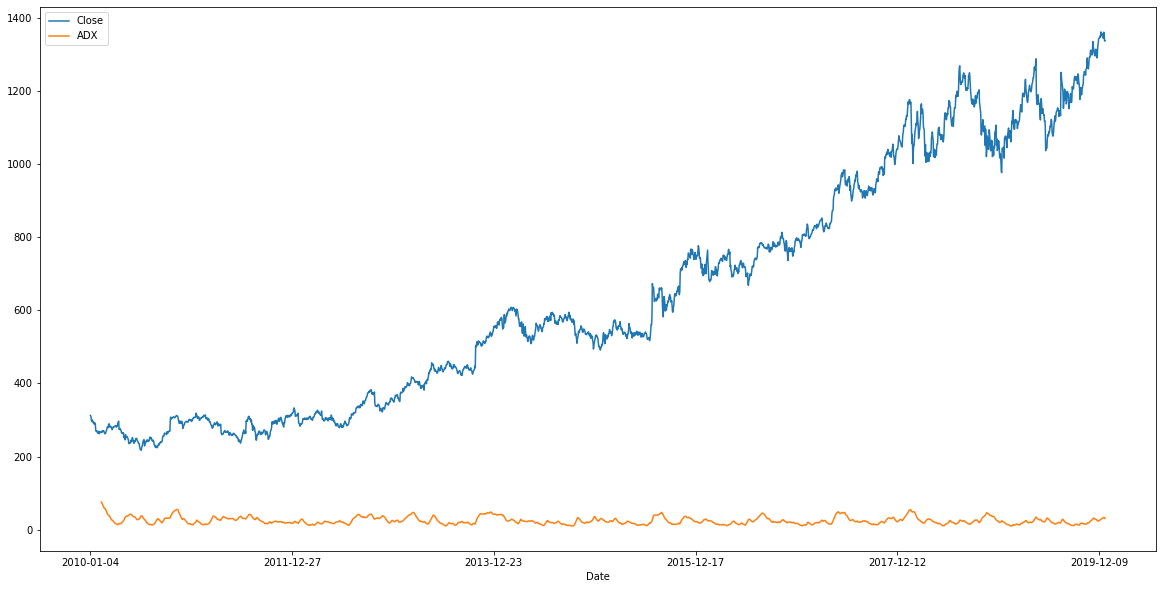

In [20]:
# Plot the Average Directional Index
goog_df[['Close', 'ADX']].plot(figsize=(20,10))

### Export Dataframe

In [ ]:
# export dataframe
goog_df.to_csv(f"Resources/goog_df_trading_signal.csv")